In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import scipy.stats as stats

import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/shie/fcr.toml")

config = Config(toml_path=toml_path)

model = Baseline(config=config)

df = pd.read_csv(model.csv_path)

ind = df.pulse_amplitude.isin([0])
df = df[~ind].reset_index(drop=True).copy()

""" Process """
df, encoder_dict = model.load(df=df)


2023-08-17 09:38:16,743 - hbmep.config - INFO - Verifying configuration ...
2023-08-17 09:38:16,744 - hbmep.config - INFO - Success!
2023-08-17 09:38:16,766 - hbmep.model.baseline - INFO - Initialized model with baseline link


2023-08-17 09:38:16,780 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/L_SHIE/fcr
2023-08-17 09:38:16,781 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/L_SHIE/fcr
2023-08-17 09:38:16,782 - hbmep.dataset.core - INFO - Processing data ...
2023-08-17 09:38:16,785 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [3]:
subjects = df.participant.unique().tolist()
combinations = model._make_combinations(df=df, columns=model.combination_columns)   # sub x pos x charge
conditions = model._make_combinations(df=df, columns=model.combination_columns[1:]) # pos x charge
conditions_inv = [f"{encoder_dict[model.features[0]].inverse_transform(np.array([pos]))[0]}::{encoder_dict[model.features[1]].inverse_transform(np.array([charge]))[0]}" for pos, charge in conditions]

muscles_map = {
    "adm": "auc_1",
    "biceps": "auc_2",
    "deltoid": "auc_4",
    "ecr": "auc_5",
    "fcr": "auc_6",
    "triceps": "auc_7"
}

In [4]:
sub_at_cond = {}

for pos, charge in conditions:
    sub_at_cond[(pos, charge)] = []
    for sub in subjects:
        if (sub, pos, charge) in combinations:
            sub_at_cond[(pos, charge)].append(sub)

In [5]:
muscles = ["deltoid", "biceps", "triceps", "ecr", "fcr", "adm"]
n_muscles = len(muscles)
a = None

for muscle in muscles:
    src = f"/home/vishu/repos/hbmep-paper/reports/L_SHIE/{muscle}"
    mcmc = az.from_netcdf(os.path.join(src, "mcmc.nc"))["posterior"]

    a_temp = mcmc[site.a].to_numpy()
    a_temp = a_temp.reshape(-1, *a_temp.shape[2:])

    b_temp = mcmc[site.b].to_numpy()
    b_temp = b_temp.reshape(-1, *b_temp.shape[2:])

    L_temp = mcmc[site.L].to_numpy()
    L_temp = L_temp.reshape(-1, *L_temp.shape[2:])

    H_temp = mcmc[site.H].to_numpy()
    H_temp = H_temp.reshape(-1, *H_temp.shape[2:])

    v_temp = mcmc[site.v].to_numpy()
    v_temp = v_temp.reshape(-1, *v_temp.shape[2:])

    if a is None:
        a = a_temp
        b = b_temp
        L = L_temp
        H = H_temp
        v = v_temp
    else:
        a = np.concatenate((a, a_temp), axis=-1)
        b = np.concatenate((b, b_temp), axis=-1)
        L = np.concatenate((L, L_temp), axis=-1)
        H = np.concatenate((H, H_temp), axis=-1)
        v = np.concatenate((v, v_temp), axis=-1)


In [6]:
a.shape

(24000, 2, 4, 8, 6)

In [5]:
x_raw = np.linspace(0, 250, 100)
x = x_raw.reshape(-1, 1, 1, 1, 1)
x = np.tile(x, (1, 2, 4, 8, 6))

In [6]:
ind = (slice(None), None, slice(None), slice(None), slice(None), slice(None))

y = L[*ind] + jnp.maximum(
    0,
    -1
    + (H[*ind] + 1)
    / jnp.power(
        1
        + (jnp.power(1 + H[*ind], v[*ind]) - 1)
        * jnp.exp(-b[*ind] * (x - a[*ind])),
        1 / v[*ind]
    )
)


In [32]:
y.shape

(24000, 100, 2, 4, 8, 6)

In [8]:
y_max = y.mean(axis=0).max(axis=(0, 1, 2))[None, None, None, None]
y = y / y_max

In [9]:
y_ratio = y / y.sum(axis=-1)[..., None]

In [21]:
entropy_adj = 1 + ((y_ratio * jnp.log(y_ratio)).sum(axis=-1) / jnp.log(n_muscles))
entropy_adj.shape

(24000, 100, 2, 4, 8)

In [ ]:
entropy_adj_hpdi = hpdi(entropy_adj)


In [30]:
np.argmax(entropy_adj.mean(axis=-1).mean(axis=0), axis=0)

Array([[ 0, 28, 27,  0],
       [ 0,  0, 11,  0]], dtype=int64)

In [31]:
entropy_adj_hpdi = hpdi(entropy_adj)


(24000, 100, 2, 4)

In [38]:
entropy_adj.shape

(24000, 100, 2, 4, 8)

In [70]:
pr = []

for i, (i_pos, i_charge) in enumerate(conditions):
    curr_pr = []

    for j, (j_pos, j_charge) in enumerate(conditions):
        if i == j:
            curr_pr.append(0)
            continue

        i_sub = set(sub_at_cond[(i_pos, i_charge)])
        j_sub = set(sub_at_cond[(j_pos, j_charge)])
        common_sub = i_sub.intersection(j_sub)
        common_sub = list(common_sub)

        assert len(common_sub) == 8

        i_entropy = entropy_adj[..., i_charge, i_pos, :]
        i_entropy = i_entropy[..., common_sub]
        i_entropy = i_entropy.mean(axis=-1)
        i_amp_ind = np.argmax(i_entropy.mean(axis=0))
        i_entropy = i_entropy[:, i_amp_ind]

        j_entropy = entropy_adj[..., j_charge, j_pos, :]
        j_entropy = j_entropy[..., common_sub]
        j_entropy = j_entropy.mean(axis=-1)
        j_amp_ind = np.argmax(j_entropy.mean(axis=0))
        j_entropy = j_entropy[:, j_amp_ind]

        curr_pr.append(((i_entropy - j_entropy) < 0).mean())

    pr.append(curr_pr)

pr = np.array(pr)

In [68]:
pr.shape

(8, 8)

In [72]:
np.argsort(-(pr > .95).sum(axis=1))

array([2, 7, 0, 1, 3, 4, 5, 6])

In [73]:
np.argsort(-pr.sum(axis=1))

array([2, 7, 6, 0, 5, 4, 1, 3])

<Axes: >

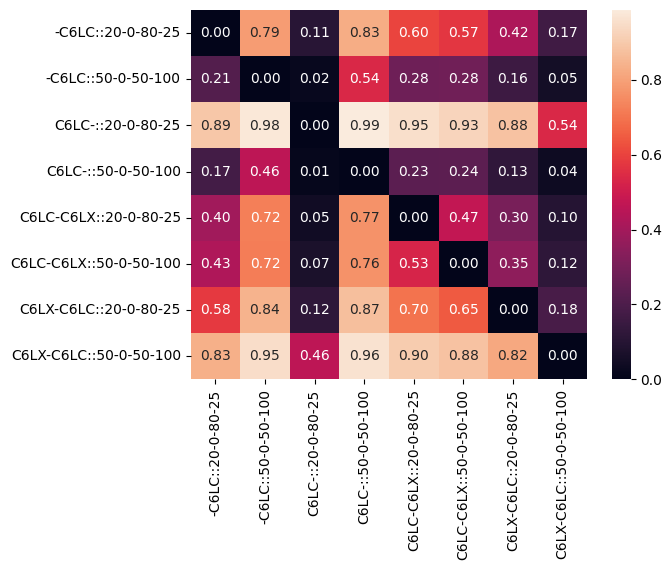

In [71]:
sns.heatmap(pr, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True, fmt=".2f")

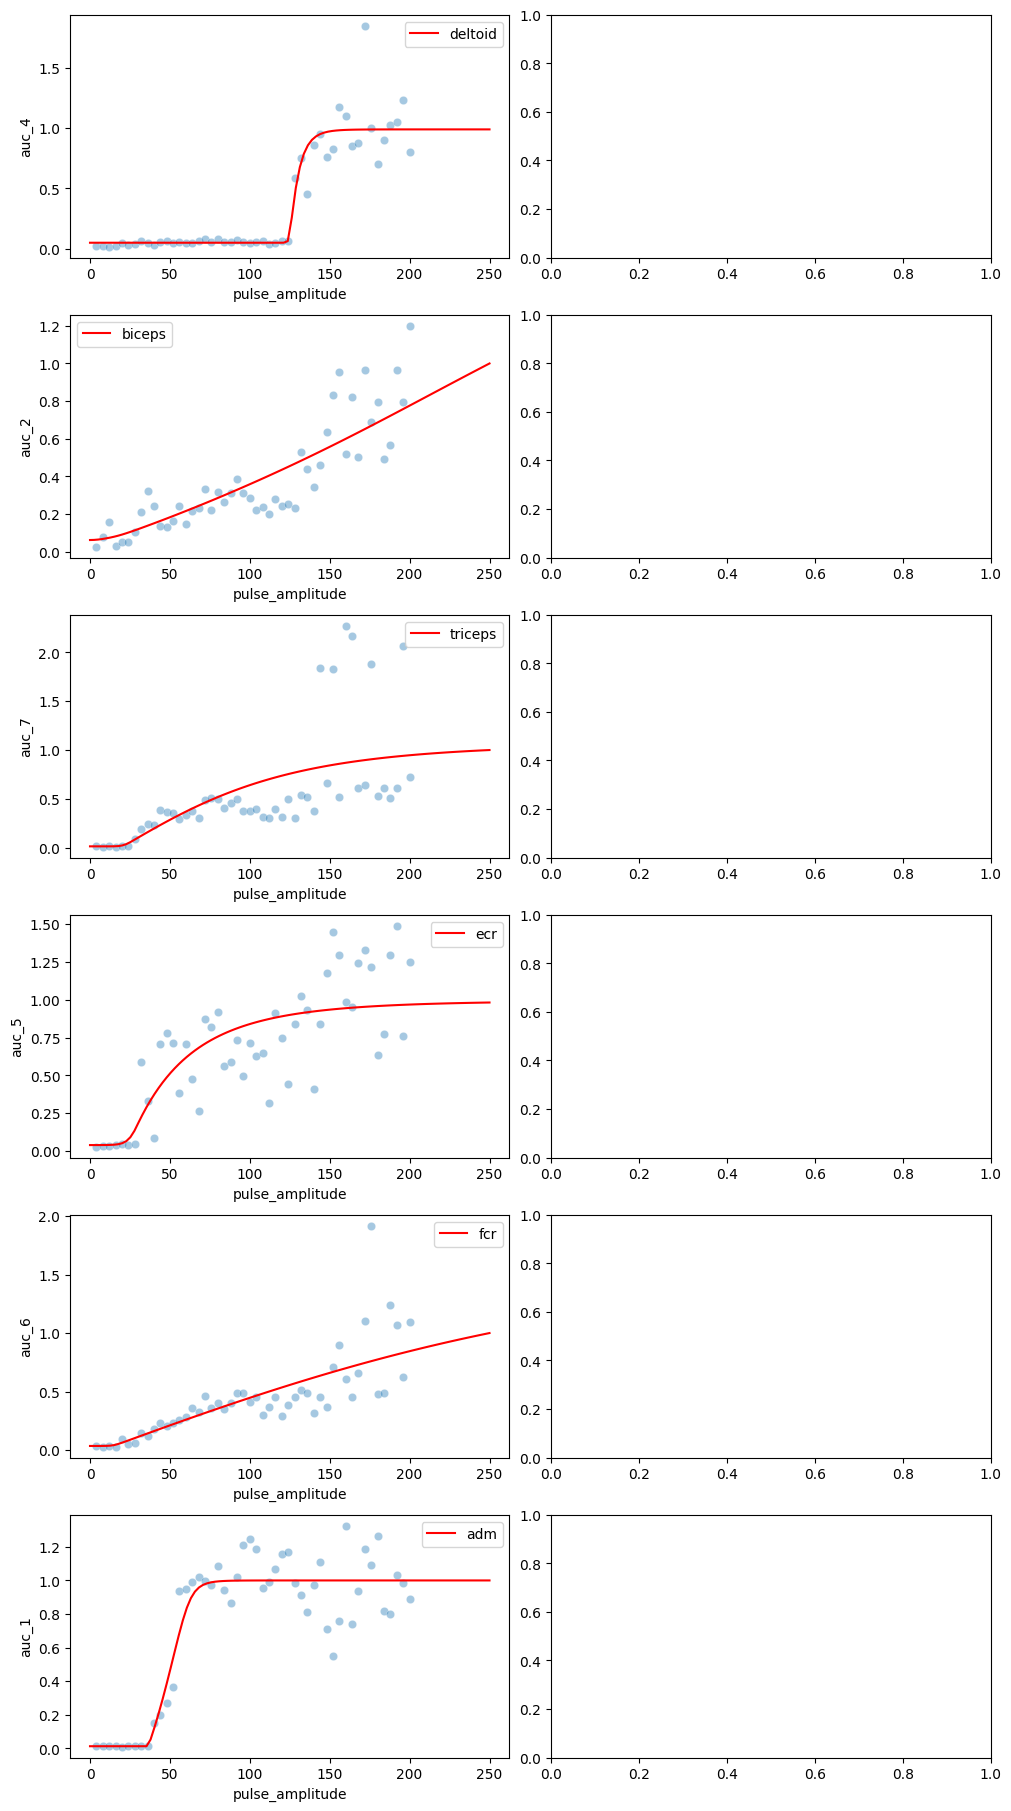

In [35]:
c = combinations[0]
ind = df[model.combination_columns].apply(tuple, axis=1).isin([c])
temp_df = df[ind].reset_index(drop=True).copy()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_muscles)))

nrows, ncols = 6, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), constrained_layout=True)

for i in range(nrows):
    muscle_ind = i
    muscle = muscles[muscle_ind]

    ax = axes[i, 0]
    sns.scatterplot(x=temp_df[model.intensity], y=temp_df[muscles_map[muscle]] / y_max[0, 0, 0, 0, c[0], muscle_ind], ax=ax, alpha=.4)
    sns.lineplot(x=x_raw, y=y.mean(axis=0)[:, c[2], c[1], c[0], muscle_ind], ax=ax, color="r", label=f"{muscle}")


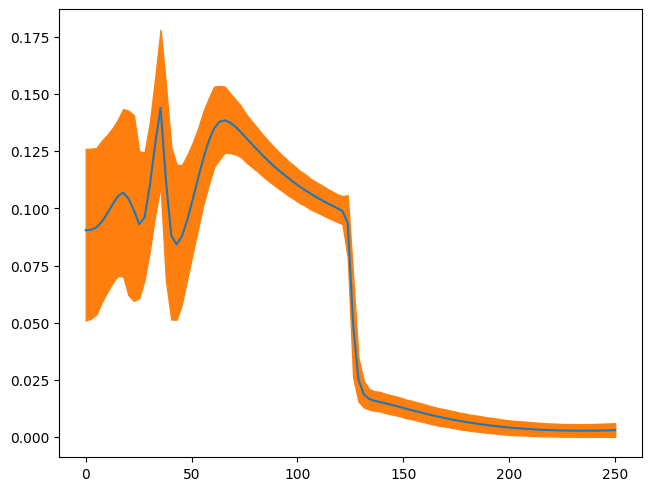

In [26]:
nrows, ncols= 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=True)

sns.lineplot(x=x_raw, y=entropy_adj.mean(axis=0)[:, c[2], c[1], c[0]])

axes.fill_between(
    x_raw,
    entropy_adj_hpdi[0, :, c[2], c[1], c[0]],
    entropy_adj_hpdi[1, :, c[2], c[1], c[0]],
    color="C1",
    label="95% HPDI"
)

In [73]:
entropy.shape

(24000, 100, 2, 4, 8)

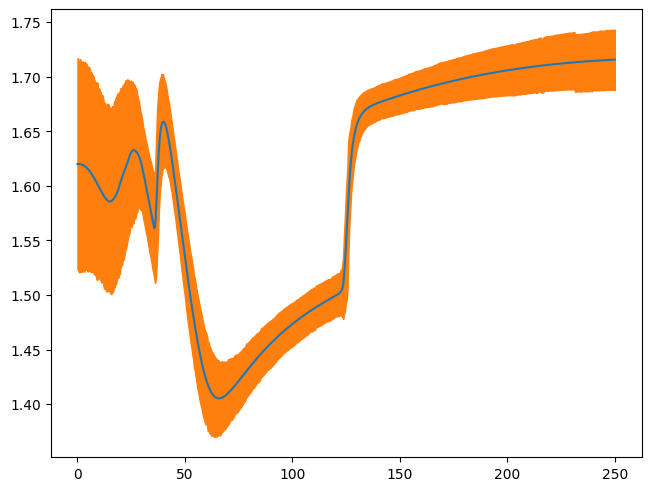

In [53]:
nrows, ncols= 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=True)

sns.lineplot(x=x[:, 0], y=entropy.mean(axis=0))

axes.fill_between(
    x[:, 0],
    entropy_hpdi[0, :],
    entropy_hpdi[1, :],
    color="C1",
    label="95% HPDI"
)

In [5]:
c = combinations[0]

n_muscles = len(muscles)
x = np.linspace(0, 250, 1000).reshape(-1, 1)
x = np.tile(x, (1, n_muscles))

ind = (slice(None), None, c[2], c[1], c[0], slice(None))

y = L[*ind] + jnp.maximum(
    0,
    -1
    + (H[*ind] + 1)
    / jnp.power(
        1
        + (jnp.power(1 + H[*ind], v[*ind]) - 1)
        * jnp.exp(-b[*ind] * (x - a[*ind])),
        1 / v[*ind]
    )
)

y_prime = \
    jnp.select(
        [
            x <= a[*ind],
            x > a[*ind],
        ],
        [
            0,
            ( b[*ind] * (1 + H[*ind]) * ( jnp.power(1 + H[*ind], v[*ind]) - 1 ) * jnp.exp(-b[*ind] * (x - a[*ind])) )
            / jnp.power(
                1
                + (jnp.power(1 + H[*ind], v[*ind]) - 1)
                * jnp.exp(-b[*ind] * (x - a[*ind])),
                (v[*ind] + 1) / v[*ind]
            )
        ]
    )

y_prime_mean = y_prime.mean(axis=0)
y_prime_sum = y_prime_mean.sum(axis=-1)[..., None]

y_prime_ratio = jnp.select(
    [
        y_prime_mean == 0,
        y_prime_mean > 0
    ],
    [
        y_prime_mean,
        y_prime_mean / y_prime_sum
    ]
)

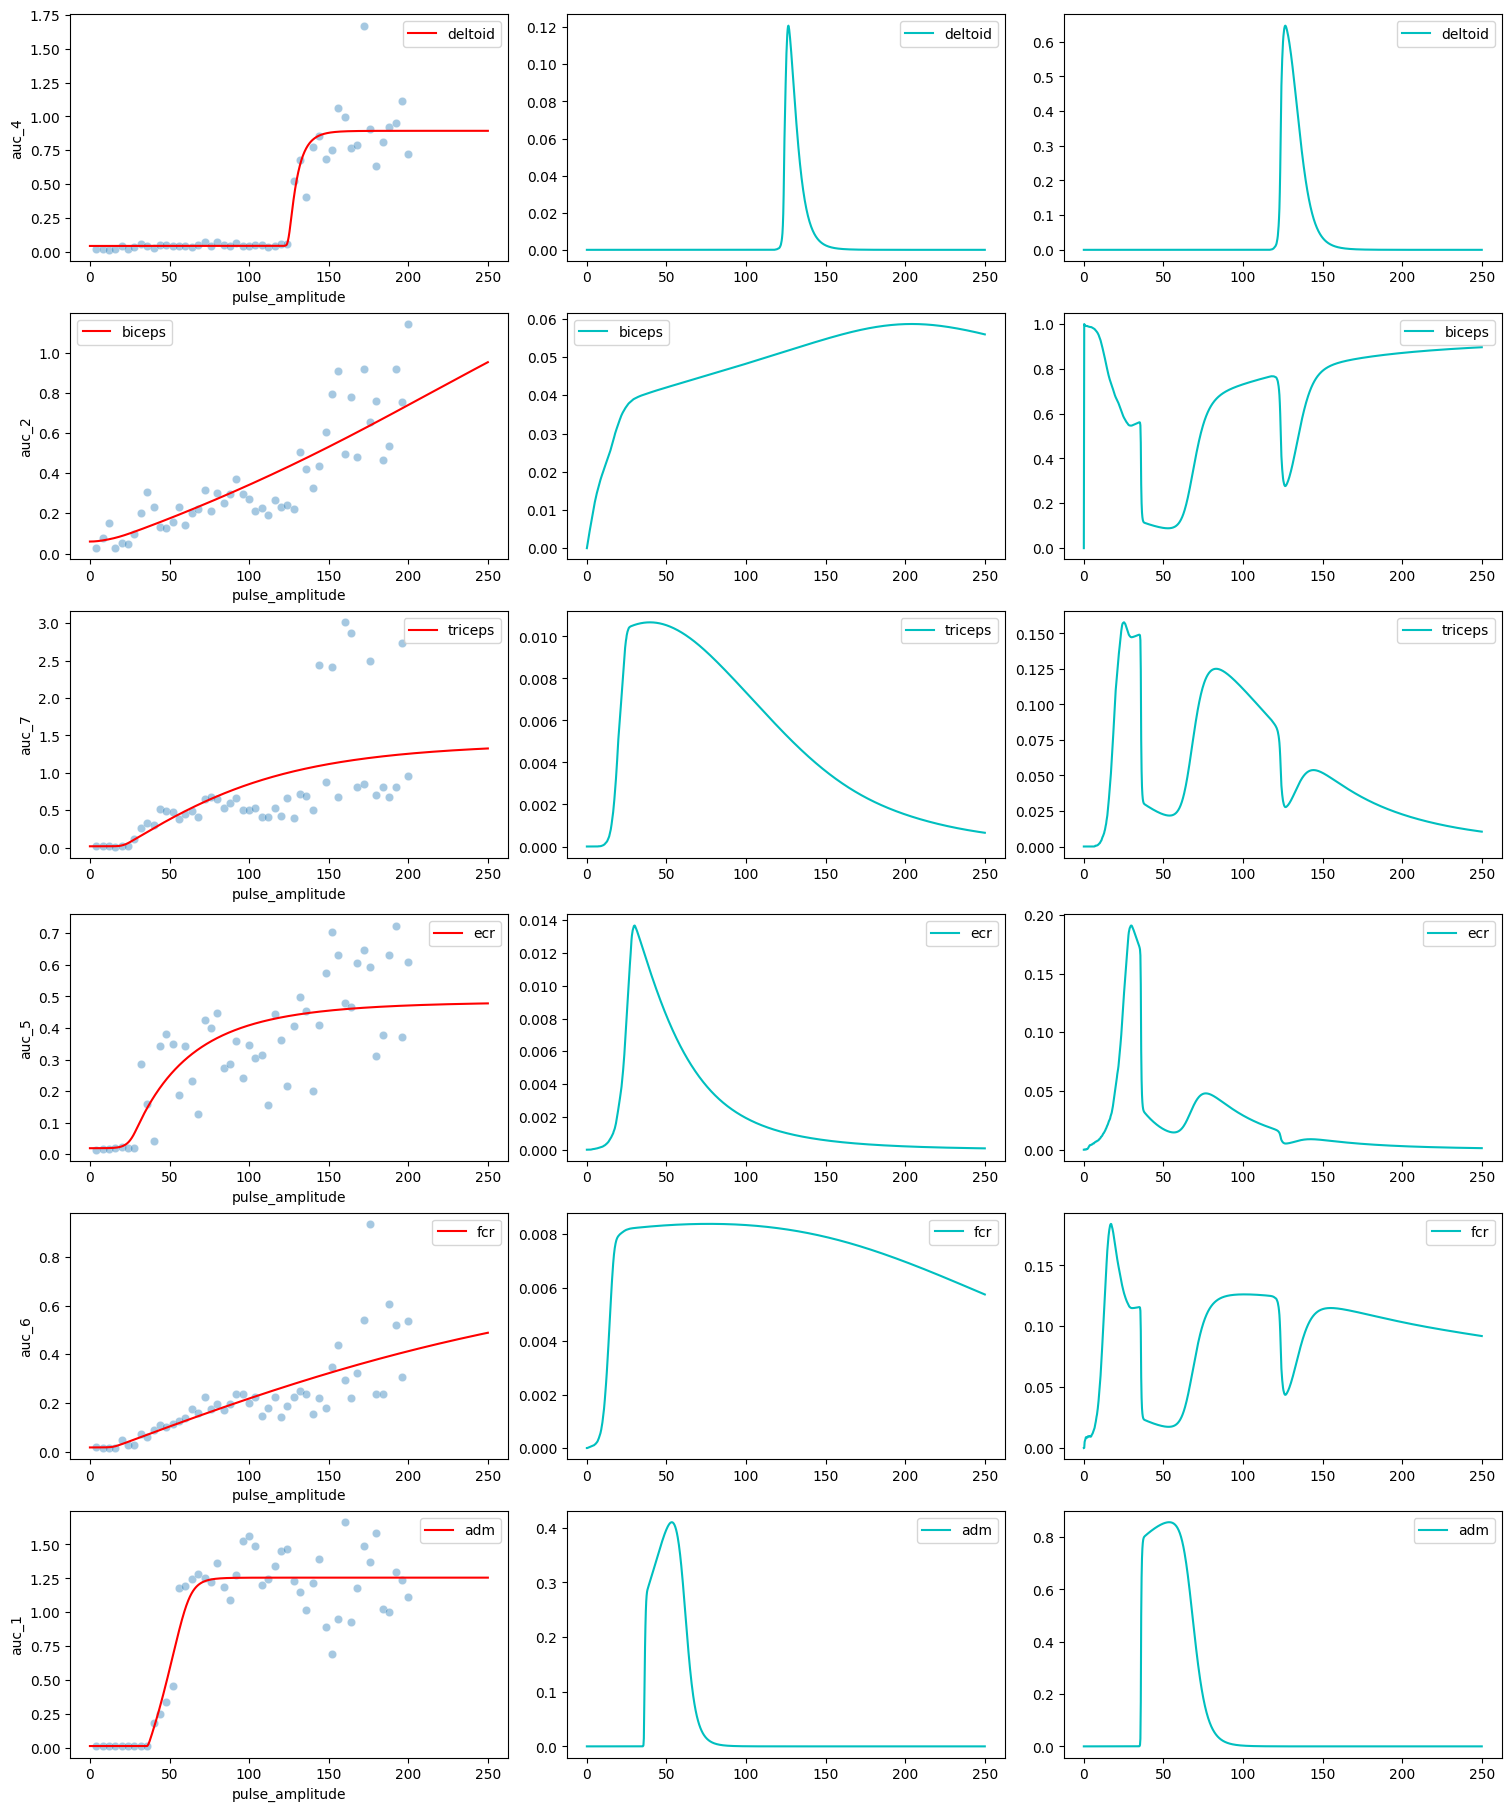

In [7]:
c = combinations[0]
ind = df[model.combination_columns].apply(tuple, axis=1).isin([c])
temp_df = df[ind].reset_index(drop=True).copy()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_muscles)))

nrows, ncols = 6, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), constrained_layout=True)

for i in range(nrows):
    muscle_ind = i
    muscle = muscles[muscle_ind]
    ax = axes[i, 0]
    sns.scatterplot(temp_df, x=model.intensity, y=muscles_map[muscle], ax=ax, alpha=.4)
    sns.lineplot(x=x[:, muscle_ind], y=y.mean(axis=0)[:, muscle_ind], ax=ax, color="r", label=f"{muscle}")

    ax = axes[i, 1]
    sns.lineplot(x=x[:, muscle_ind], y=y_prime_mean[:, muscle_ind], ax=ax, color="c", label=f"{muscle}")

    ax = axes[i, 2]
    sns.lineplot(x=x[:, muscle_ind], y=y_prime_ratio[:, muscle_ind], ax=ax, color="c", label=f"{muscle}")

    muscle_ind += 1

<Axes: >

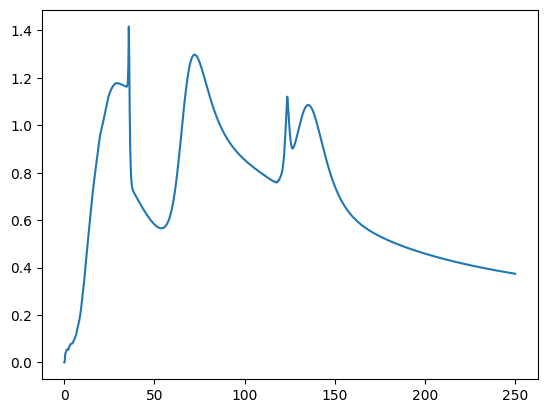

In [8]:
entropy = jnp.select(
    [
        y_prime_ratio == 0,
        y_prime_ratio > 0
    ],
    [
        y_prime_ratio,
        - y_prime_ratio * jnp.log(y_prime_ratio)
    ]
)

sns.lineplot(x=x[:, 0], y=entropy.sum(axis=-1))